# Figure 5: GRB afterglow

## Loading the BHNS population

In [6]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
import h5py
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
import scipy
from scipy import stats
from scipy.integrate import cumtrapz
from scipy.ndimage import gaussian_filter as gf
from matplotlib.lines import Line2D
import pandas
import corner
import random
import sympy as sp
import os
from scipy.interpolate import RegularGridInterpolator
from functions import * 
import sys
sys.path.insert(0, '../COMPAS')
from spin_class import * 
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

num = 1000000 #number of binaries
eos = "SFHo" #assumed EoS
table = h5py.File('./population_data/bhns_%i_%s_z10_mass_spin_thv_GWFAST.hdf5' %(num,eos),'r') #EM and GW population
mns_max = 2.058838 #NS maximum mass for the assumed SFHo EoS

DCOtype='BHNS'
poptype='A'
path = './population_data/COMPASCompactOutput_'+ DCOtype + '_' + poptype+'.h5' #from Broekgaarden+21 

distribution = 'NOT fixed' #or 'fixed' for the same mass distribution at each redshift (approximated redshift evolution)
spin_prescription = 'Zero' #/Qin21/Uniform/Bavera21

### --- Loading Population --- ###

print("Loading intrinsic population")
mbh = table['mbh'][()] #mass of the primary component
mns = table['mns'][()] #mass of the secondary component
lamb_ns = table['lamb_ns'][()] #NS deformability
spin_bh = table['spin_bh'][()] #BH spin
i_tilt = table['i_tilt'][()] #angle between spin and angular momentum 
z = table['z'][()] #redshift
dL = table['dL'][()] #luminosity distance
thv = table['thv'][()] #viewing angle
ra = table['ra'][()]
dec = table['dec'][()]
m_dyn = table['m_dyn'][()] #dynamical ejecta mass
v_dyn = table['v_dyn'][()] #dynamical ejecta velocity
m_disk = table['m_disk'][()] #disk mass
m_out = table['m_out'][()] #ejected mass
final_x = table['final_x'][()] #final spin
E_bkt = table['E_bkt'][()] #brekout energy
E_k_jet = table['E_k_jet'][()] #jet kinetic energy
Ec = table['Ec'][()] #jet core energy

print("Loading GW population")
snr_LVKO4_duty = table['snr_LVKO4_duty'][()] #SNRs LVK O4
snr_LVKIO5_duty = table['snr_LVKIO5_duty'][()] #SNRs LVKI O5

print("Loading EM population (GRB afterglow)")
grb_nu = table['grb_nu'][()] #GRB afterglow bands
t_grb = table['t_grb'][()] #GRB afterglow time
lc_grb = table['lc_grb'][()] #GRB afterglow flux

table.close()

Loading intrinsic population
Loading GW population
Loading EM population (GRB afterglow)


In [7]:
def mJy_to_ABmag(flux):
    AB_mag = 2.5*(23-np.log10(flux*1.e-3))-48.6
    return AB_mag
def mJy_to_nuFnu(nu,flux):    
    nuFnu = nu * 4.*np.pi * 1.e-26*(flux)
    return nuFnu
def smoothing(H,sm):
    g = gf(H,sm)
    gr = g.ravel()
    s = np.argsort(gr)
    cr = np.empty(gr.shape)
    cr[s] = np.cumsum(gr[s])
    c = np.reshape(cr/cr.max(),g.shape)
    return c 

In [8]:
### --- Weights --- ###

if poptype == 'A':
    w_type='w_000'
    r0 = 149 #43
    w_type_high = 'w_000' #w_231
    r0_high = 302 #200
    w_type_low = 'w_000' #w_312
    r0_low = 62
    
if poptype == 'B':
    w_type='w_000'
    r0 = 20
    w_type_high = 'w_000' #w_231
    r0_high = 100
    w_type_low = 'w_312' #w_312
    r0_low = 10

spin = calculate_spin_olderCOMPASdata(data_path=path)
if spin_prescription == 'Bavera21':
    spinM1, spinM2  = spin.Bavera21()
if spin_prescription == 'Qin21':
    spinM1, spinM2  = spin.Qin21()
if spin_prescription == 'Uniform':
    spinM1, spinM2  = spin.Bavera21()
    spinM1 = np.random.uniform(0.,0.5,spinM1.shape)
    spinM2 = np.random.uniform(0.,0.5,spinM2.shape)
elif spin_prescription == 'Zero':
    spinM1, spinM2  = spin.Bavera21()
    spinM1 = np.random.uniform(0.,0.,spinM1.shape)
    spinM2 = np.random.uniform(0.,0.,spinM2.shape)

bhx=[2.5,27]
nsx=[1.1,3]
spinx=[0.,1.]
binsx=50
binsy=50
binsz=50

if distribution == 'fixed':
    C_mc, w = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0,5.e-2,path,w_type,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
  
if distribution == 'NOT fixed':
    C_mc, w = f_weights(mbh,mns,thv,spin_bh,z,r0,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)

print("")
print("EoS:",eos)
print("Population model:",poptype)
print("The mass and spin distributions are", distribution)
if distribution == 'fixed':
    print("The fiducial SFRD is", w_type, "with r0 =", r0)
    print("The higher limit SFRD is", w_type_high, "with r0 =", r0_high)
    print("The lower limit SFRD is", w_type_low, "with r0 =", r0_low)
print("The spin prescription is:", spin_prescription)
print("")

Computing weights

EoS: SFHo
Population model: A
The mass and spin distributions are NOT fixed
The spin prescription is: Zero



In [9]:
#GW
print("Computing GW limiting thresholds")
lim_snr = 12
gw_det = snr_LVKIO5_duty >= lim_snr

Computing GW limiting thresholds


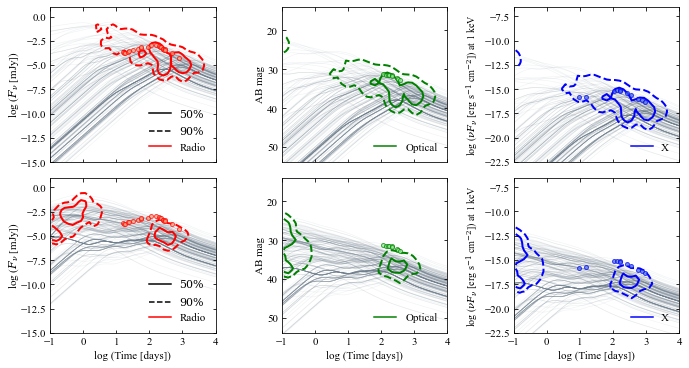

In [10]:
recomp_gaussian = False
recomp_uniform = False
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['figure.autolayout']=True
plt.rcParams['mathtext.fontset']='dejavuserif'
plt.rcParams["axes.axisbelow"] = False

fig = plt.figure(figsize =([9.5, 6]))
gs = fig.add_gridspec(nrows=2, ncols=3,hspace=0.1,wspace=0.4,left=0.06,right=0.98)

thetaj = [3.4,15]

bins=40
smooth = 1.0

for h in range(len(thetaj)):

    num_angle = h
    
    ax1 = fig.add_subplot(gs[h, 0])
    ax2 = fig.add_subplot(gs[h, 1])
    ax3 = fig.add_subplot(gs[h, 2])

    grb_peak = np.max(lc_grb, axis=2)
    grb_det = np.zeros([num,len(grb_nu)],dtype=bool)
  
    ### --- Plotting Peak Luminosity --- ### 

    pc2cm = 3.085678e+18 

    #GRB70817A Afterglow (Makhathini et al. 2020)
    mag_gw170817_o=flux_to_app(1.11e-4*1.e-26) #from mJy to cgs
    flux_gw170817_o=app_to_flux(mag_gw170817_o)

    gw170817_x = 2.41e17 * 4.*np.pi * (40. * 3.086e24)**2 / (1. + 0.009) * 3.37e-6 * 1.e-26   #2.4e17 
    gw170817_r = 1.3e9 * 4.*np.pi * (40. * 3.086e24)**2 / (1. + 0.009) * 1.84e-1 * 1.e-26     #1.4e9 
    gw170817_o = 5.06e14 * 4.*np.pi * (40. * 3.086e24)**2 / (1. + 0.009) * flux_gw170817_o    #4.6e14 

    ################----- RADIO
    color_grb = ['red','green','blue']

    #Plotting lc samples        
    random.seed(0)
    ind = np.linspace(0,num-1,num,dtype="int")
    ran = random.choices(ind,weights=w*gw_det*(Ec[:,num_angle]>0)*(m_disk>1.e-5),k=300)

    for i in range(0,len(ran)):
        #plt.plot(np.log10(t_grb),np.log10(lc_grb[ran[i],0,:,num_angle]),c="slategray",linewidth=0.6,alpha=0.1,zorder=1)
        ax1.plot(np.log10(t_grb),np.log10(lc_grb[ran[i],0,:,num_angle]),c="slategray",linewidth=0.6,alpha=0.1,zorder=1)

    #Plotting lc peak
    grb_peak_nu = grb_peak[:,0,num_angle]

    t_peak = t_grb[np.argmax(lc_grb, axis=2)]
    t_peak_nu = t_peak[:,0,num_angle]

    H, xedges, yedges= np.histogram2d(np.log10(t_peak_nu[(Ec[:,num_angle]>0)*(m_disk>1.e-4)]),np.log10(grb_peak_nu[(Ec[:,num_angle]>0)*(m_disk>1.e-4)]),weights=(w*gw_det)[(Ec[:,num_angle]>0)*(m_disk>1.e-4)],bins=bins)

    c = smoothing(H,smooth)

    xcentre = np.zeros(bins)
    ycentre = np.zeros(bins)

    for j in range(len(xedges)-1):
        xcentre[j] = xedges[j] + (xedges[j+1] - xedges[j]) / 2.

    for j in range(len(yedges)-1):
        ycentre[j] = yedges[j] + (yedges[j+1] - yedges[j]) / 2.

    T, M = np.meshgrid(xcentre, ycentre, indexing='ij')
    ax1.contour(T,M,c,levels=[0.1,0.5],colors=color_grb[0],linestyles=['--','-'],linewidths=2.,zorder=2)

    if h == 1:
        ax1.set_xlabel(r'log (Time [days])',size=11)
    ax1.set_ylabel(r'log ($F_\nu$ [mJy])',size=11,labelpad=0.1)
    ax1.set_ylim((-15,1))
    ax1.set_xlim((-1,4))

    ################----- OPTICAL
    #Plotting lc samples        
    random.seed(0)
    ind = np.linspace(0,num-1,num,dtype="int")
    ran = random.choices(ind,weights=w*gw_det*(Ec[:,num_angle]>0)*(m_disk>1.e-5),k=300)

    for i in range(0,len(ran)):
        ax2.plot(np.log10(t_grb),mJy_to_ABmag(lc_grb[ran[i],1,:,num_angle]),c="slategray",linewidth=0.6,alpha=0.1,zorder=1)

    grb_peak_nu = mJy_to_ABmag(grb_peak[:,1,num_angle])

    t_peak = t_grb[np.argmax(lc_grb, axis=2)]
    t_peak_nu = t_peak[:,1,num_angle]

    H, xedges, yedges= np.histogram2d(np.log10(t_peak_nu[(Ec[:,num_angle]>0)*(m_disk>1.e-4)]),grb_peak_nu[(Ec[:,num_angle]>0)*(m_disk>1.e-4)],weights=(w*gw_det)[(Ec[:,num_angle]>0)*(m_disk>1.e-4)],bins=bins)

    c = smoothing(H,smooth)

    xcentre = np.zeros(bins)
    ycentre = np.zeros(bins)

    for j in range(len(xedges)-1):
        xcentre[j] = xedges[j] + (xedges[j+1] - xedges[j]) / 2.

    for j in range(len(yedges)-1):
        ycentre[j] = yedges[j] + (yedges[j+1] - yedges[j]) / 2.

    T, M = np.meshgrid(xcentre, ycentre, indexing='ij')
    ax2.contour(T,M,c,levels=[0.1,0.5],colors=color_grb[1],linestyles=['--','-'],linewidths=2.,zorder=2)
    if h == 1:
        ax2.set_xlabel(r'log (Time [days])',size=11)
    ax2.set_ylabel(r'AB mag',size=11,labelpad=2)
    mn, mx = ax1.get_ylim()
    ax2.set_ylim(mJy_to_ABmag(10**(mn)), mJy_to_ABmag(10**(mx)))
    ax2.set_xlim((-1,4))

    ################----- X
    #Plotting lc samples        
    random.seed(0)
    ind = np.linspace(0,num-1,num,dtype="int")
    ran = random.choices(ind,weights=w*gw_det*(Ec[:,num_angle]>0)*(m_disk>1.e-5),k=300)

    for i in range(0,len(ran)):
        ax3.plot(np.log10(t_grb),np.log10(mJy_to_nuFnu(2.41e17,lc_grb[ran[i],2,:,num_angle])),c="slategray",linewidth=0.6,alpha=0.1,zorder=1)

    grb_peak_nu = mJy_to_nuFnu(2.41e17,grb_peak[:,2,num_angle])

    t_peak = t_grb[np.argmax(lc_grb, axis=2)]
    t_peak_nu = t_peak[:,2,num_angle]

    H, xedges, yedges= np.histogram2d(np.log10(t_peak_nu[(Ec[:,num_angle]>0)*(m_disk>1.e-4)]),np.log10(grb_peak_nu[(Ec[:,num_angle]>0)*(m_disk>1.e-4)]),weights=(w*gw_det)[(Ec[:,num_angle]>0)*(m_disk>1.e-4)],bins=bins)

    c = smoothing(H,smooth)

    xcentre = np.zeros(bins)
    ycentre = np.zeros(bins)

    for j in range(len(xedges)-1):
        xcentre[j] = xedges[j] + (xedges[j+1] - xedges[j]) / 2.

    for j in range(len(yedges)-1):
        ycentre[j] = yedges[j] + (yedges[j+1] - yedges[j]) / 2.

    T, M = np.meshgrid(xcentre, ycentre, indexing='ij')
    ax3.contour(T,M,c,levels=[0.1,0.5],colors=color_grb[2],linestyles=['--','-'],linewidths=2.,zorder=2)
    if h == 1:
         ax3.set_xlabel(r'log (Time [days])',size=11)
    ax3.set_ylabel(r'log ($\nu F_\nu$ [erg s$^{-1}$ cm$^{-2}$]) at 1 keV',size=10)
    mn, mx = ax1.get_ylim()
    ax3.set_ylim(np.log10(mJy_to_nuFnu(2.41e17,10**mn)), np.log10(mJy_to_nuFnu(2.41e17,10**mx)))
    ax3.set_xlim((-1,4))
    #ax3.text(3.5,9.,"GRB Afterglow O5",ha='right',size=11)
    #ax3.text(3.5,11.,r"$\theta_j = 15^\circ$",ha='right',size=11)

    #########------- DATA GRB170817A

    t_x,f_x,grb170817_x,errhigh_x,errlow_x=np.loadtxt("./GRB170817A/afterglow_x.txt", usecols=[0,1,2,3,4],unpack=True)
    t_r,f_r,grb170817_r,err_r=np.loadtxt("./GRB170817A/afterglow_r.txt", usecols=[0,1,2,3],unpack=True)
    t_o,f_o,grb170817_o,err_o=np.loadtxt("./GRB170817A/afterglow_o.txt", usecols=[0,1,2,3],unpack=True)

    W = w*gw_det*(m_out>0.)
    s = np.argsort(dL)
    dL_cdf = np.cumsum(W[s])
    dL_cdf/=dL_cdf[-1]
    dL0 = np.sort(dL)
    dL_median = np.interp(0.5,dL_cdf,dL0)

    scale_dis = (dL_median**2)/(40**2)
    after_r = grb170817_r*1.e-3/scale_dis
    err_after_r = err_r*1.e-3/scale_dis
    ax1.errorbar(np.log10(t_r),np.log10(after_r),markersize=4,markerfacecolor="lightsalmon",color='red',ls='None',marker='o',zorder=2,alpha=0.7)

    after_x = grb170817_x*1.e-3/scale_dis
    errhigh_after_x = errhigh_x*1.e-3/scale_dis
    errlow_after_x = errlow_x*1.e-3/scale_dis
    ax3.errorbar(np.log10(t_x),np.log10(mJy_to_nuFnu(2.41e17,after_x)),markersize=4,markerfacecolor="royalblue",color='blue',ls='None',marker='o',zorder=2,alpha=0.7)

    after_o = grb170817_o*1.e-3/scale_dis
    err_after_o = err_o*1.e-3/scale_dis
    ax2.errorbar(np.log10(t_o),mJy_to_ABmag(after_o),markersize=4,markerfacecolor="lightgreen",color='green',ls='None',marker='o',zorder=2,alpha=0.7)

    ax1.legend([Line2D([0],[0],color='black'),Line2D([0],[0],color='black',ls='--'),Line2D([0],[0],color='red')],[r'$50\%$',r'$90\%$','Radio'],loc=4,prop={'size': 11},frameon=False)
    ax2.legend([Line2D([0],[0],color='green')],['Optical'],loc=4,prop={'size': 11},frameon=False)
    ax3.legend([Line2D([0],[0],color='blue')],['X'],loc=4,prop={'size': 11},frameon=False)

    if h == 0:
        ax1.tick_params(direction='in',bottom=True,top=True,left=True,right=True,labelsize=11)
        ax2.tick_params(direction='in',bottom=True,top=True,left=True,right=True,labelsize=11)
        ax3.tick_params(direction='in',bottom=True,top=True,left=True,right=True,labelsize=11)
        ax1.axes.xaxis.set_ticklabels([])
        ax2.axes.xaxis.set_ticklabels([])
        ax3.axes.xaxis.set_ticklabels([])
        
    if h == 1:
        ax1.tick_params(direction='in',bottom=True,top=True,left=True,right=True,labelsize=11)
        ax2.tick_params(direction='in',bottom=True,top=True,left=True,right=True,labelsize=11)
        ax3.tick_params(direction='in',bottom=True,top=True,left=True,right=True,labelsize=11)

plt.savefig("afterglow.pdf")        
plt.show()
